# TP1: Recommendation

*By Daniel Deutsch and Kevin Kühl*

In [1]:
from time import time

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy import sparse
from scipy.optimize import check_grad
from scipy.sparse.linalg import svds

In [2]:
rho = 0.3

# 1) Presentation of the Model

In [3]:
def load_movielens(filename, minidata=False):
    data = np.loadtxt(filename, dtype=int)
    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)), dtype=float)
    
    # Not optimized for big data
    R = R.toarray()

    # Obtaining function 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape), (data[:, 0]-1, data[:, 1]-1)), dtype=bool)
    
    # Not optimized for big data
    mask = mask.toarray()

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask

### Question 1.1

- The **minidata** argument on the load_movielens function (if True) reduces the data to a 100x200 dimension.

In [4]:
R, mask = load_movielens("./datasets/ml-100k/u.data")
print(f"The R matrix has size {R.shape}")

The R matrix has size (943, 1682)


### Question 1.2

In [5]:
print(f"There are {R.shape[0]} users and {R.shape[1]} films in the dataset.\nThe total number of grades is {mask.sum()}.")

There are 943 users and 1682 films in the dataset.
The total number of grades is 100000.


### Remark on objective function

The objective function to be minimized in P and Q can be written as (considering P and Q scalars)

$$g(p,q) = \frac{1}{2}(r - pq)^2 + \frac{\rho}{2}(p^2 + q^2)$$

In order to observe the behavior of this function in the three dimensional space, besides taking scalars values for p and q, we will consider, without loss of generality, r equal to 5.

This yields the following plot, which shows that it is not convexity.

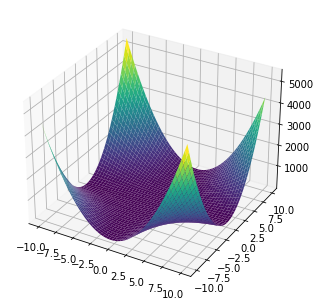

In [6]:
fig = plt.figure(1)
ax = Axes3D(fig)

X = np.arange(-10, 10, 0.1)
Y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(X, Y)
Z = (5 - X*Y)**2/2. + rho/2.*(X**2 + Y**2)
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

# 2) Find $P$ when $Q^0$ is Fixed 

### Question 2.1

To find the gradient of the function $g$ we need to obtain the derivative in relation to $P$:

<br>

\begin{aligned}
    \nabla g(P) \quad = \quad \frac{\partial g}{\partial P} \quad & = \quad \frac{\partial}{\partial P} \left(\frac{1}{2} ||1_K \circ (R - Q^0 P) ||_F^2 + \frac{\rho}{2}||Q^0||_F^2 + \frac{\rho}{2} ||P||_F^2\right) \\
    & = \quad \frac{\partial}{\partial P} \left(\frac{1}{2} ||1_K \circ (R - Q^0 P) ||_F^2\right) + \underbrace{\frac{\partial}{\partial P} \left(\frac{\rho}{2}||Q^0||_F^2\right)}_\text{= 0} + \frac{\partial}{\partial P} \left(\frac{\rho}{2} ||P||_F^2\right) \\
    & = \quad \left(-\frac{2}{2} \left(Q^0\right)^T [1_K \circ (R - Q^0 P)]\right) + \left(\frac{\rho}{2} 2 P\right) \\
    & = \quad -\left(Q^0\right)^T [1_K \circ (R - Q^0 P)] + \rho P
\end{aligned}

### Question 2.2

In [7]:
def objective(P, Q0, R, mask, rho):
    tmp = (R - Q0.dot(P)) * mask
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))
    grad_P = -Q0.T.dot(tmp) + rho*P
    return val, grad_P

In [8]:
def objective_fnc(P_vec, Q0, R, mask, rho, k):
    P = P_vec.reshape(k, R.shape[1])
    val, grad_P = objective(P, Q0, R, mask, rho)
    return val

def gradient_objective_fnc(P_vec, Q0, R, mask, rho, k):
    P = P_vec.reshape(k, R.shape[1])
    val, grad_P = objective(P, Q0, R, mask, rho)
    return grad_P.ravel()

Q0, S, P0 = svds(R, k=4, return_singular_vectors=True)

t_start = time()
err = check_grad(objective_fnc, gradient_objective_fnc, np.zeros_like(P0).ravel(), Q0, R, mask, rho, 4)

print(f"The error of the obtained gradient is: {err}")
print(f"Time spent: {time() - t_start}s")

The error of the obtained gradient is: 0.7670578158495761
Time spent: 153.25861120224s


### Question 2.3

In [9]:
def gradient(g, P0, gamma, epsilon):
    Pk = P0
    val, grad_Pk = g(Pk, Q0, R, mask, rho)
    gradient_norms = []
    while (np.sum(grad_Pk**2) > epsilon**2):
        Pk -= gamma*grad_Pk
        val, grad_Pk = g(Pk, Q0, R, mask, rho)
        gradient_norms.append(np.linalg.norm(grad_Pk))
    return val, Pk, gradient_norms

### Question 2.4

The achieved minimized objective function value: 369551.5497551458
Time spent: 0.660698652267456s


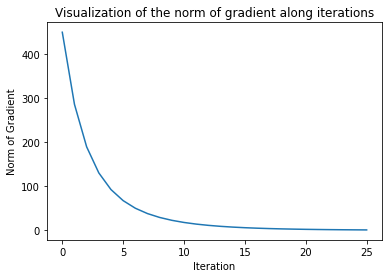

In [10]:
epislon = 1
L = rho + np.linalg.norm((Q0.T).dot(Q0), ord="fro")
gamma = 1./L

t_start = time()

val_min_grad, P_grad, gradient_norms_grad = gradient(objective, np.zeros_like(P0), gamma, epislon)

print(f"The achieved minimized objective function value: {val_min_grad}")
print(f"Time spent: {time() - t_start}s")

# Plotting gradients over iterations
plt.plot(gradient_norms_grad)
plt.title("Visualization of the norm of gradient along iterations")
plt.xlabel("Iteration")
plt.ylabel("Norm of Gradient")
plt.show()

### Question 2.5

In [11]:
def gradient_LS(g, P0, a=0.5, b=0.25, beta=0.5, epsilon=1):
    gradient_norms = []
    Pk = P0
    val, grad_Pk = g(Pk, Q0, R, mask, rho)
    grad_norm_squared = np.linalg.norm(grad_Pk, ord="fro")**2
    gamma = b
    while (grad_norm_squared > epsilon**2):
        gamma *= 2
        val_, grad_Pk_ = g(Pk - gamma*grad_Pk, Q0, R, mask, rho)
        while (val_ > val - gamma*beta*grad_norm_squared):
            gamma *= a
            val_, grad_Pk_ = g(Pk - gamma*grad_Pk, Q0, R, mask, rho)
        Pk -= gamma*grad_Pk
        val = val_
        grad_Pk = grad_Pk_
        grad_norm_squared = np.linalg.norm(grad_Pk, ord="fro")**2
        gradient_norms.append(np.linalg.norm(grad_Pk, ord="fro"))
    return val, Pk, gradient_norms

The achieved minimized objective function value: 369551.4030373625
Time spent: 0.2986783981323242s


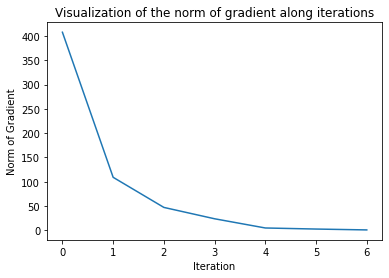

In [12]:
t_start = time()
val_min_grad_ls, P_grad_ls, gradient_norms_grad_ls = gradient_LS(objective, np.zeros_like(P0))

print(f"The achieved minimized objective function value: {val_min_grad_ls}")
print(f"Time spent: {time() - t_start}s")

# Plotting gradients over iterations
plt.plot(gradient_norms_grad_ls)
plt.title("Visualization of the norm of gradient along iterations")
plt.xlabel("Iteration")
plt.ylabel("Norm of Gradient")
plt.show()

# 3) Resolution of the Full Problem

### Question 3.1

If f is a polynomial of degree 4, then its gradient is a polynomial of degree 3.

**Theorem:** *Let f: I $\rightarrow$ R be differentiable, with the property that |$\nabla f(x)$| $\leq$ M, $\forall x \in I$.*

*Then, |f(x) - f(y)| $\leq$ M|x-y|, for all x $\in$ I.*

Therefore, if $\nabla f(x)$ is Lipschitz continuous, one can use the inverse of the above theorem to imply that $\nabla^2 f(x)$ will be bounded.

If f is a polynomial of degree 4, $\nabla^2 f(x)$ is a polynomial of degree 2. Therefore, it is not bounded.

Therefore, $\nabla f(x)$ is not Lipschitz continuous.

### Question 3.2

In [13]:
def total_objective(P, Q, R, mask, rho):
    tmp = (R - Q.dot(P)) * mask
    val = np.sum(tmp**2)/2. + rho/2.*(np.sum(Q**2) + np.sum(P**2))
    grad_P = -Q.T.dot(mask*(R - Q.dot(P))) + rho*P
    grad_Q = -(mask*(R - Q.dot(P))).dot(P.T) + rho*Q
    return val, grad_P, grad_Q

def total_objective_vectorized(PQvec, R, mask, rho):

    # Reconstruction of P and Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = PQvec.shape[0] // (n_items + n_users)
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))

    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, np.concatenate([grad_P.ravel(), grad_Q.ravel()])

In [14]:
def gradient_LS_vectorized(g, PQ0, a=0.5, b=0.25, beta=0.5, epsilon=1):
    gradient_norms = []
    PQk = PQ0
    val, grad_PQk = g(PQk, R, mask, rho)
    grad_norm_squared = np.linalg.norm(grad_PQk)**2
    gamma = b
    while (grad_norm_squared > epsilon**2):
        gamma = 2 * gamma
        PQk_ = PQk - gamma*grad_PQk
        val_, grad_PQk_ = g(PQk_, R, mask, rho)
        while (val_ > val - gamma*beta*grad_norm_squared):
            gamma = gamma*a
            PQk_ = PQk - gamma*grad_PQk
            val_, grad_PQk_ = g(PQk_, R, mask, rho)
        PQk = PQk_
        val = val_
        grad_PQk = grad_PQk_
        grad_norm_squared = np.linalg.norm(grad_PQk)**2
        gradient_norms.append(np.linalg.norm(grad_PQk))
    return val, PQk, gradient_norms

In [15]:
t_start = time()

val_min_grad_ls_vec, PQ_grad_ls_vec, gradient_norms_grad_ls_vec = gradient_LS_vectorized(total_objective_vectorized, np.concatenate([P0.ravel(), Q0.ravel()]), epsilon=100)

n_users, n_items = R.shape
F = PQ_grad_ls_vec.shape[0]//(n_items + n_users)
Pvec = PQ_grad_ls_vec[0:n_items*F]
Qvec = PQ_grad_ls_vec[n_items*F:]
P_grad = np.reshape(Pvec, (F, n_items))
Q_grad = np.reshape(Qvec, (n_users, F))

print(f"The achieved minimized objective function value: {val_min_grad_ls_vec}")
print(f"Time spent: {time() - t_start}s")

The achieved minimized objective function value: 36092.80541112955
Time spent: 13.02202820777893s


The algorithm's returned value corresponds to an estimation of the error between the obtained and estimated scores. Also, it returns the values of P and Q for which it is achieved.

### Question 3.3

In [19]:
R_grad = Q_grad.dot(P_grad)
not_mask = np.logical_not(mask)
estimated_R = R_grad*not_mask
score = estimated_R[300, :].reshape(-1)

print(f"Based on the calculated score ({np.max(score):.4f}), the recommended movie will be {np.argmax(score)}")

Based on the calculated score (4.5630), the recommended movie will be 312
